<a href="https://colab.research.google.com/github/CristianAlegreBustos/BusesDatabaseApi/blob/main/Smoking_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Informe Ejecutivo

## 1) Antecedentes

El propósito central de este proyecto es construir un modelo capaz de predecir la probabilidad de que una persona sea fumadora basándose en un conjunto de características de salud.

En principio el conjunto de datos tiene un desbalance de un 63% de fumadores y un 37% de no fumadores.
En el Analisis Exploratorio de Datos se encontro que las caracteristicas mas importantes son: El Genero ('gender'), Mediciones de Gtp ('Gtp'), Sarro ('Tartar'), Caries ('Dental Caries').
Algo importante a tener en cuenta es que el modelo tiene un 63% de Genero Femenino y un 37% de Genero Masculino.

Si evaluamos la cantidad de hombres fumadores vs no fumadores y la cantidad de mujeres fumadoras vs no fumadoras.

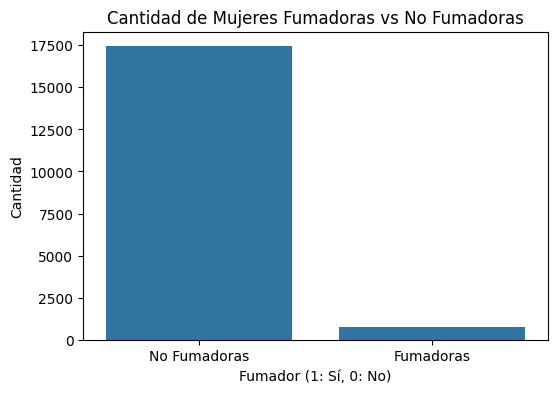

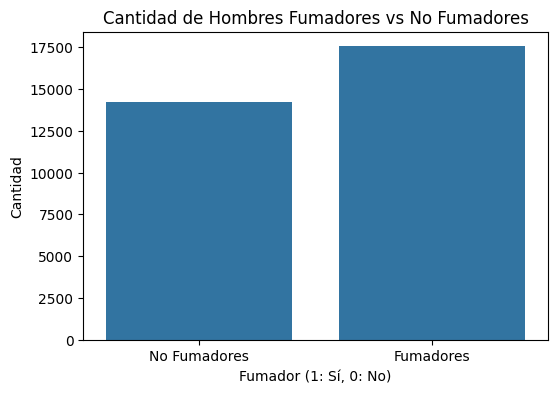

El analisis nos muestra que que la mayoria de las mujeres que tenemos en nuestro dataframe no son fumadoras y estas representan el 95.7 % de todos los individuos de genero femenino. En los hombres esta mas balanceado ya que el 44,8 % no son fumadores y el 55.2% si son fumadores.

Con este analisis un modelo basico de arbol de decision podria memorizar : Si el genero es femenino, entonces no es fumadora. Por esta razon se realizo un primer MVP  utilizanfo XGboost y randomOversampler para tratar de equilibrar las clases.

### Primeros Modelos
  Como primer intento se realizo un mvp utilizando arbol de decision y se utilizo XGboost para que busque las mejores relaciones entre caracteristicas y evitar la memorizacion usando solo el genero. Se utilizo RandomOverSampler para tratar el desiquilibrio entre las clases.  Tambien usamos optuna para buscar los mejores hiperparametros para el modelo.
  Este es el colab: https://colab.research.google.com/drive/1-yy8tySUOsZzJKdISXUd9VLTNJjerkjL?usp=sharing

  Se visualiza overfiting para la clase no fumadora. Cuando se hace la evaluacion por train y test separado por genero femenino y masculino el overfiting es aun mas evidente.
  De hecho la precision del modelo para no fumadoras del genero femenino es 96% y coincide con el dato que se vio en el eda del 95.7 % para el mismo genero.
  Se Grafica las 20 features mas importantes que tomo el modelo y se concluye que el modelo usa la feature genero para decidir si un individuo es fumadora o no.
  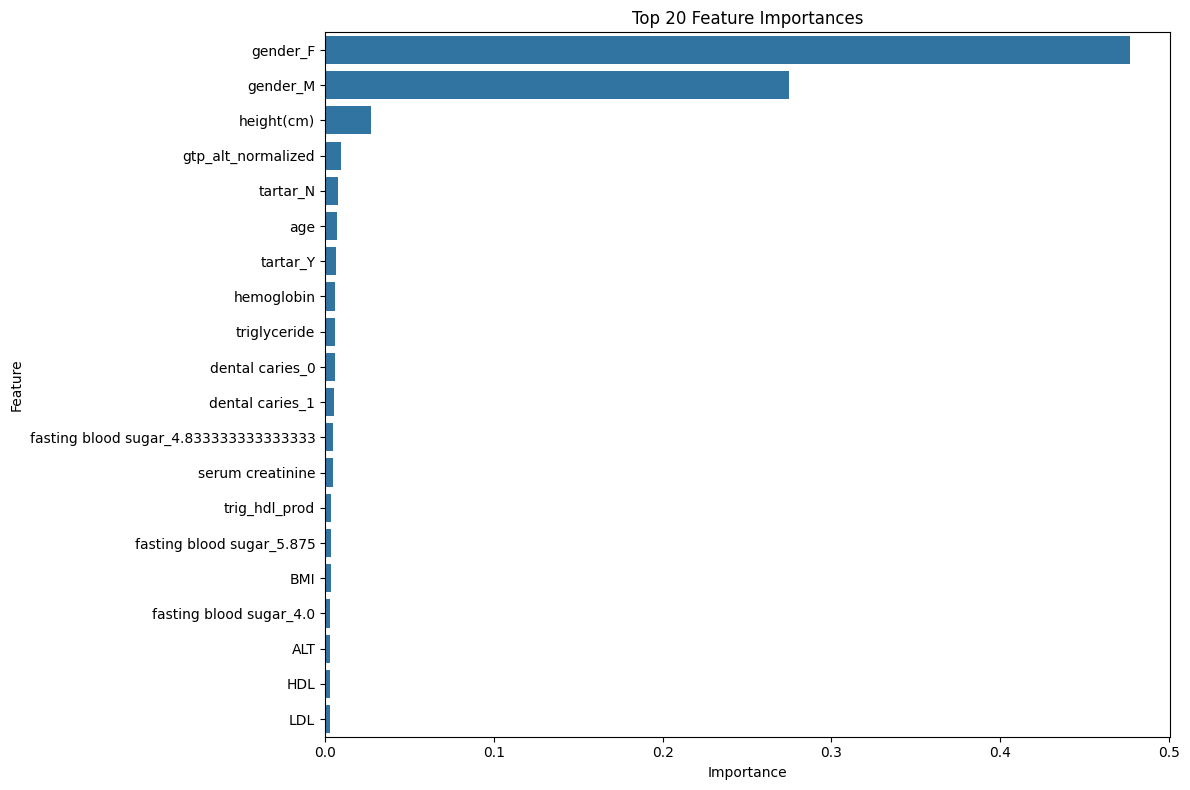


Este comportamiento del modelo no asegura que generalice bien al recibir datos muy diferentes a los que fue entrenado, por ejemplo, al recibir datos un individuo femenino y fumador.
Reconociendo el desbalance entre clases se optó por un enfoque de modelado separado para hombres y mujeres. Esto permite una mayor especificidad en el aprendizaje de patrones y una optimización más precisa de los modelos para cada grupo.

## 2) Metodologia

La metodología se estructuró en varias fases clave:


*   **Carga y Preprocesamiento de Datos:** Se cargó el conjunto de datos smoking_prediction.xlsx. Se realizó una exhaustiva ingeniería de características, creando nuevas variables como el Índice de Masa Corporal (BMI), la relación cintura-altura, y diversas relaciones entre mediciones de colesterol, triglicéridos y enzimas hepáticas (e.g., chol_hdl_ratio, gtp_alt_normalized). Se eliminaron columnas irrelevantes o redundantes (ID, oral, waist(cm)).

*   **División del Conjunto de Datos:** Los datos se dividieron en conjuntos de entrenamiento y prueba, estratificando por la variable objetivo 'smoking' para asegurar que la proporción de fumadores y no fumadores se mantuviera en ambos conjuntos, lo cual es crucial dado el desequilibrio de clases.

* **Preprocesamiento por Pipeline:** Se diseñó un pipeline robusto para el preprocesamiento de datos, que incluyó:
  * **Imputación:** Relleno de valores faltantes utilizando la mediana para características numéricas y una constante para categóricas.
  * **Escalado:** Estandarización de las características numéricas para que tuvieran media cero y varianza unitaria.
  * **Codificación One-Hot:** Transformación de variables categóricas en un formato numérico adecuado para el modelado.
  * **Binarización Custom:** Se implementó una binarización específica para la característica gtp_alt_normalized, dividiéndola en cuartiles para capturar relaciones no lineales. De esta forma nos aseguramos visibilidad de gtp tanto para el modelo femenino como el masculino.
  Esto es porque en promedio, los individuos fumadores tienen el gtp mas alto que los no fumadores. No fumadores: 1.29, Fumadores: 2.32

  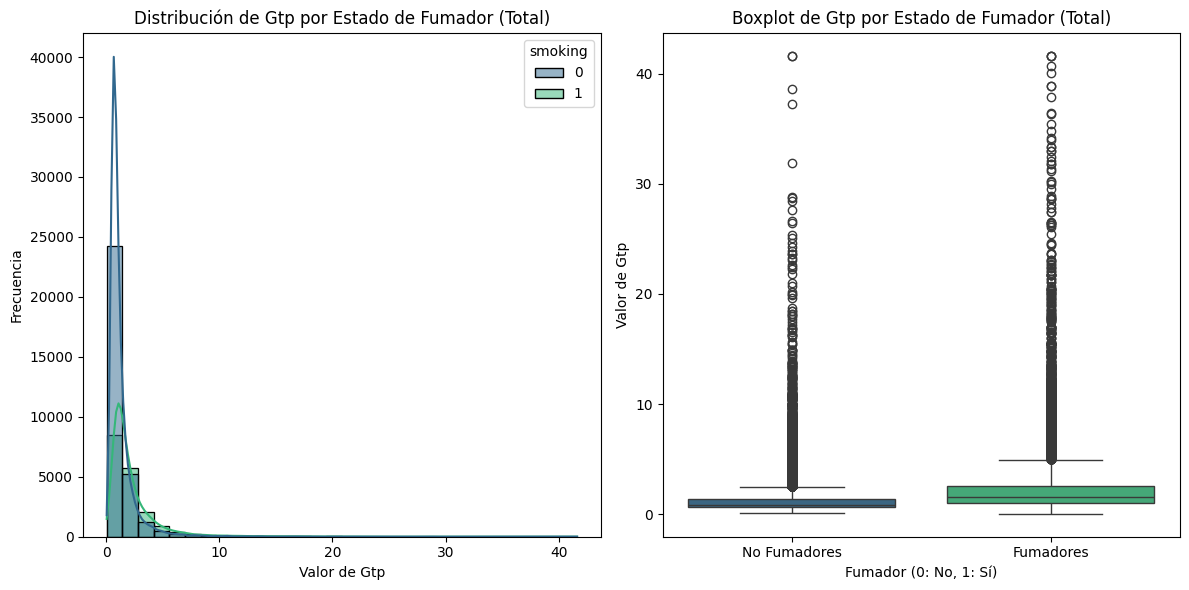

  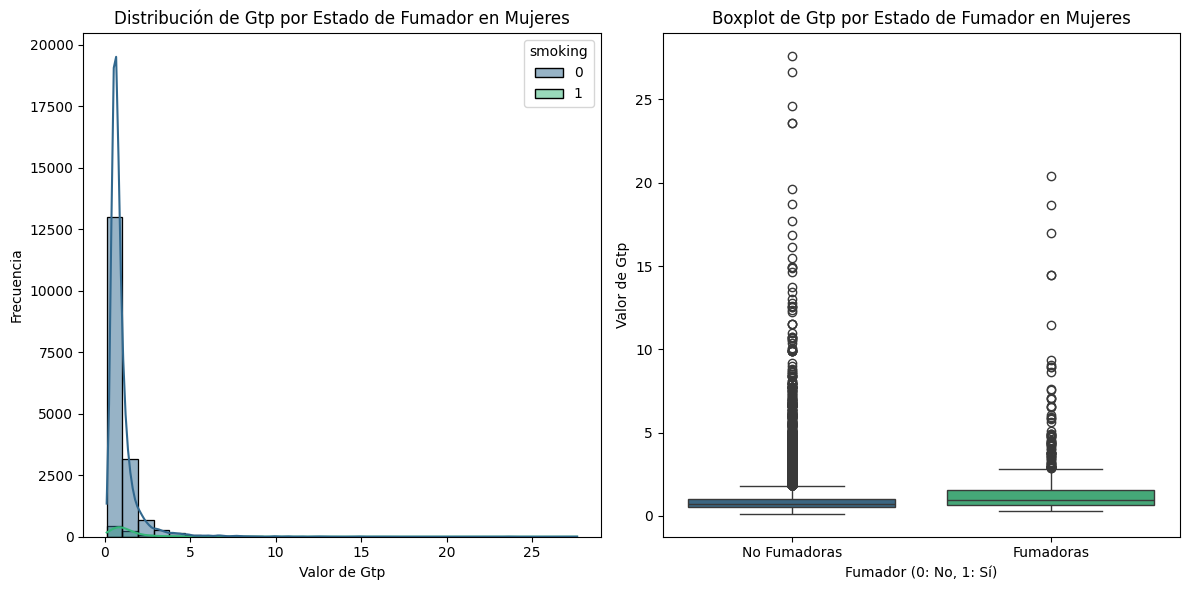

  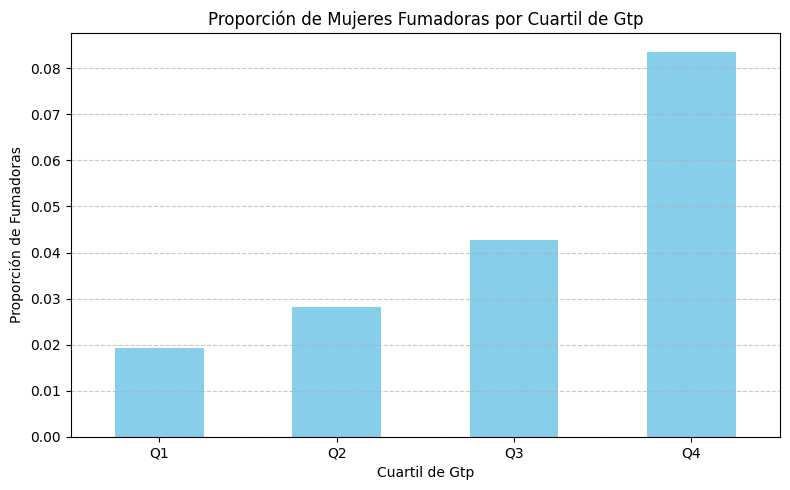

* **Modelado por Género con XGBoost:** Se entrenaron dos modelos XGBoost (Extreme Gradient Boosting), uno para el subconjunto de datos de mujeres y otro para el de hombres. XGBoost fue elegido por su eficacia en problemas de clasificación y su capacidad para manejar grandes conjuntos de datos.
* **Optimización de Hiperparámetros con Optuna:** Para cada modelo de género, se utilizó Optuna, una biblioteca de optimización de hiperparámetros, para encontrar la combinación óptima de parámetros que maximizara el rendimiento del modelo (medido por el área bajo la curva ROC, ROC AUC).
* **Manejo del Desequilibrio de Clases:** Dada la prevalencia de no fumadores sobre fumadores, especialmente notoria en el subconjunto femenino, se aplicó SMOTE (Synthetic Minority Over-sampling Technique) al modelo femenino para generar ejemplos sintéticos de la clase minoritaria (fumadores) y así mejorar su capacidad de aprendizaje. Para el modelo masculino, se ajustó el parámetro scale_pos_weight en XGBoost para dar mayor importancia a la clase minoritaria.

### 2.1 Metodologias, tecninas o librerias aprendidas de forma autodidacta

1) **Optuna :** En el proyecto use optuna para optimizar mejor los hiperparametros del modelo. Esto no quita que no haya tenido en cuenta que probar diferentes rangos de max_depth, n_estimator, learning rates. De hecho al diseñar dos modelos diferentes tuve que pensar y buscar dos pipelines de hiperparametros defirentes. Esto me forzo a que tuviera que jugar y aprender un poco mas sobre cada hiperparametro y por supuesto que use optuna para ayudarme con esto. Optuna lo aprendi de de otras practicas que realice y viendo esta documentacion: https://aetperf.github.io/2021/02/16/Optuna-+-XGBoost-on-a-tabular-dataset.html

Formas en los cuales me ayudo optuna en el modelo:


*   Utilizando algoritmos de optimizacion bayesiana explora los mejores hiperparametros. Para esto aprende de los resultados de las pruebas anteriores para decidir qué combinaciones de hiperparámetros probar a continuación, dirigiéndose a las regiones más prometedoras.

*   Permite definir el espacio de búsqueda de hiperparámetros de forma dinámica, lo que es muy flexible. Dentro de `def objective(trial)` , le indico a Optuna qué hiperparámetros quiero optimizar y en qué rangos, y luego le indico la métrica de rendimiento que quiero maximizar (en mi caso, roc_auc_score).

*   Pruning (Poda): Optuna puede detener pruebas poco prometedoras antes de que terminen. Si una combinación de hiperparámetros está rindiendo muy mal en las primeras etapas del entrenamiento, Optuna puede "podar" (detener) esa prueba, ahorrando tiempo y recursos computacionales que de otro modo se desperdiciarían.

*   Manejo de Desbalance de Clases: Optuna también me ayudo a encontrar el `scale_pos_weight` óptimo para el modelo femenino, que es un hiperparámetro crucial para manejar el desequilibrio de clases en XGBoost.

Sobre scale_pos_weight, este es un hiperparámetro clave en XGBoost que entra a jugar cuando tenés un desbalance heavy entre las clases, como pasa con las fumadoras y no fumadoras en el dataset femenino. Básicamente le esta diciendo al modelo que le preste atencion a la clase minoritaria. Lo que hace es ponderar más los errores que comete el modelo al intentar predecir a la clase "positiva" (en este caso, las fumadoras). Así, si el scale_pos_weight es 5, un error clasificando a una fumadora es 5 veces "más grave" que un error con una no fumadora. Esto fuerza al algoritmo a ser mucho más cuidadoso y a aprender mejor los patrones de la clase que tiene menos ejemplos, evitando que simplemente se incline por la clase mayoritaria (que es lo que le pasaría si no le das este "empujón"). En el modelo femenino, Optuna fue clave para tratar de dar con el valor justo y que no se nos escape ninguna fumadora por el desbalance.

**2) Calculo de umbrales optimos. **

Para asegurar que nuestras predicciones fueran lo más útiles posible, especialmente con el desbalance de clases, no nos quedamos con el umbral de probabilidad por defecto de 0.5. En su lugar, implementamos una función `find_optimal_threshold `que se zambulle en las probabilidades predichas del modelo y calcula el F1-Score (que para mí es clave porque equilibra precisión y recall, dándonos una visión honesta del rendimiento) para cada posible punto de corte. De esta forma, podemos identificar explícitamente el umbral de probabilidad que maximiza ese F1-Score, garantizando que el modelo clasifique de la manera más efectiva posible, priorizando un balance adecuado entre identificar correctamente a los fumadores sin generar demasiados falsos positivos, lo cual es fundamental para la interpretación de los resultados.



In [4]:
!pip install xgboost optuna imbalanced-learn openpyxl --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Primeras 5 filas del dataset original ---
   ID gender  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0      F   40         155          60   3.377083        0.043056   
1   1      F   40         160          60   3.375000        0.005556   
2   2      M   55         170          60   3.333333        0.005556   
3   3      M   40         165          70   3.666667        0.045139   
4   4      F   40         155          60   3.583333        0.041667   

   eyesight(right)  hearing(left)  hearing(right)  ...  hemoglobin  \
0         0.041667       0.041667        0.041667  ...    0.506250   
1         0.004167       0.041667        0.041667  ...    0.504861   
2         0.005556       0.041667        0.041667  ...    0.630556   
3         0.045139       0.041667        0.041667  ...    0.588194   
4         0.041667       0.041667        0

[I 2025-06-26 22:58:10,153] A new study created in memory with name: no-name-c7a05a4d-5046-4995-8e8b-fac3d05ec3af



--- Entrenando modelo para F ---
Calculado scale_pos_weight inicial (ratio): 22.03971119133574


[I 2025-06-26 22:58:13,192] Trial 0 finished with value: 0.6851148948834045 and parameters: {'n_estimators': 240, 'max_depth': 4, 'learning_rate': 0.02511077772816236, 'subsample': 0.8744205478577605, 'colsample_bytree': 0.9648450895555782, 'gamma': 1.5782641402058444, 'reg_lambda': 19.169196050333355, 'reg_alpha': 6.4480807467500245, 'min_child_weight': 20, 'max_delta_step': 2, 'scale_pos_weight': 23.77646250010077}. Best is trial 0 with value: 0.6851148948834045.
[I 2025-06-26 22:58:15,976] Trial 1 finished with value: 0.6973509342516422 and parameters: {'n_estimators': 221, 'max_depth': 5, 'learning_rate': 0.05145685936816573, 'subsample': 0.8742729397040214, 'colsample_bytree': 0.9337757053565778, 'gamma': 1.6947401208768424, 'reg_lambda': 11.45248394966044, 'reg_alpha': 11.195764449622168, 'min_child_weight': 17, 'max_delta_step': 4, 'scale_pos_weight': 2.450039919503235}. Best is trial 1 with value: 0.6973509342516422.
[I 2025-06-26 22:58:22,532] Trial 2 finished with value: 0.70


F TRAIN (Default 0.5 Threshold)
 Accuracy: 0.8199623942337825
 ROC AUC: 0.9546365203404915
 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     12210
           1       0.19      0.96      0.32       554

    accuracy                           0.82     12764
   macro avg       0.59      0.89      0.61     12764
weighted avg       0.96      0.82      0.87     12764


F TEST (Default 0.5 Threshold)
 Accuracy: 0.7837490829053558
 ROC AUC: 0.7219216461535191
 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      5227
           1       0.10      0.51      0.16       225

    accuracy                           0.78      5452
   macro avg       0.54      0.65      0.52      5452
weighted avg       0.94      0.78      0.85      5452

Mejores parámetros para FEMENINO: {'n_estimators': 205, 'max_depth': 6, 'learning_rate': 0.09413308348694245, 'subs

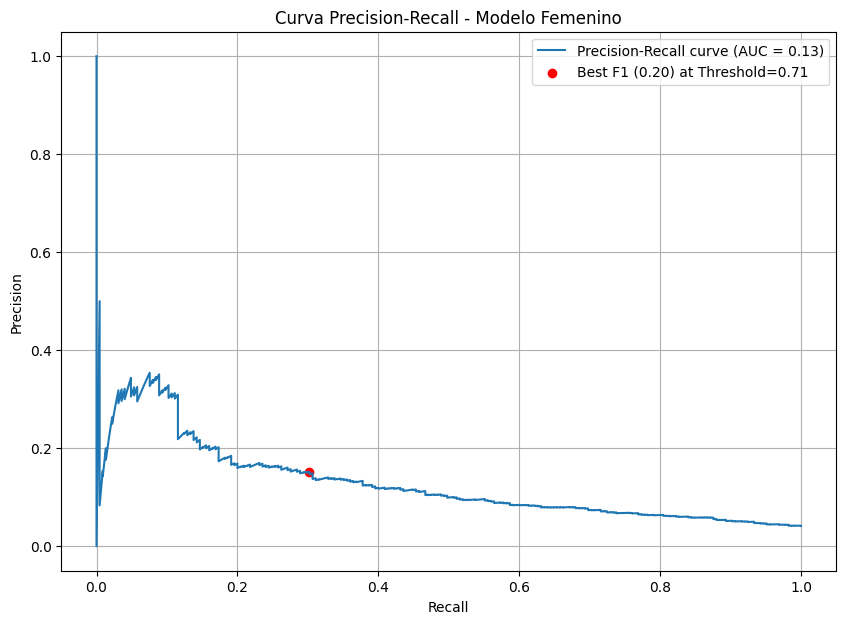

[I 2025-06-26 23:01:56,980] A new study created in memory with name: no-name-58d47cfa-ed22-4ad5-9600-f52ae8890129


Optimal Threshold (Max F1): 0.7064
Precision at optimal threshold: 0.1518
Recall at optimal threshold: 0.3022
F1-score at optimal threshold: 0.2021

# --- Entrenamiento del Modelo Masculino ---

--- Entrenando modelo para M ---
Calculado scale_pos_weight inicial (ratio): 0.8113391984359726


[I 2025-06-26 23:01:57,824] Trial 0 finished with value: 0.6988212763223903 and parameters: {'n_estimators': 209, 'max_depth': 3, 'learning_rate': 0.07089830029248649, 'subsample': 0.7647925062578348, 'colsample_bytree': 0.704655128277014, 'gamma': 6.67992991830715, 'reg_lambda': 65.90305987069895, 'reg_alpha': 30.81770418379638, 'min_child_weight': 35, 'max_delta_step': 2}. Best is trial 0 with value: 0.6988212763223903.
[I 2025-06-26 23:01:58,861] Trial 1 finished with value: 0.6913424851590936 and parameters: {'n_estimators': 189, 'max_depth': 3, 'learning_rate': 0.026904902592628156, 'subsample': 0.9105713309514922, 'colsample_bytree': 0.6489778418835331, 'gamma': 5.452500154706243, 'reg_lambda': 53.94553423884399, 'reg_alpha': 32.49314118181548, 'min_child_weight': 25, 'max_delta_step': 4}. Best is trial 0 with value: 0.6988212763223903.
[I 2025-06-26 23:01:59,900] Trial 2 finished with value: 0.6912000119248966 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate'


M TRAIN (Default 0.5 Threshold)
 Accuracy: 0.6747616477783774
 ROC AUC: 0.7400032600260933
 Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      9960
           1       0.72      0.67      0.69     12276

    accuracy                           0.67     22236
   macro avg       0.67      0.68      0.67     22236
weighted avg       0.68      0.67      0.68     22236


M TEST (Default 0.5 Threshold)
 Accuracy: 0.6470465018852115
 ROC AUC: 0.7075109901585888
 Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      4274
           1       0.70      0.64      0.67      5274

    accuracy                           0.65      9548
   macro avg       0.65      0.65      0.65      9548
weighted avg       0.65      0.65      0.65      9548

Mejores parámetros para MASCULINO: {'n_estimators': 378, 'max_depth': 4, 'learning_rate': 0.06301630509309045, 'sub

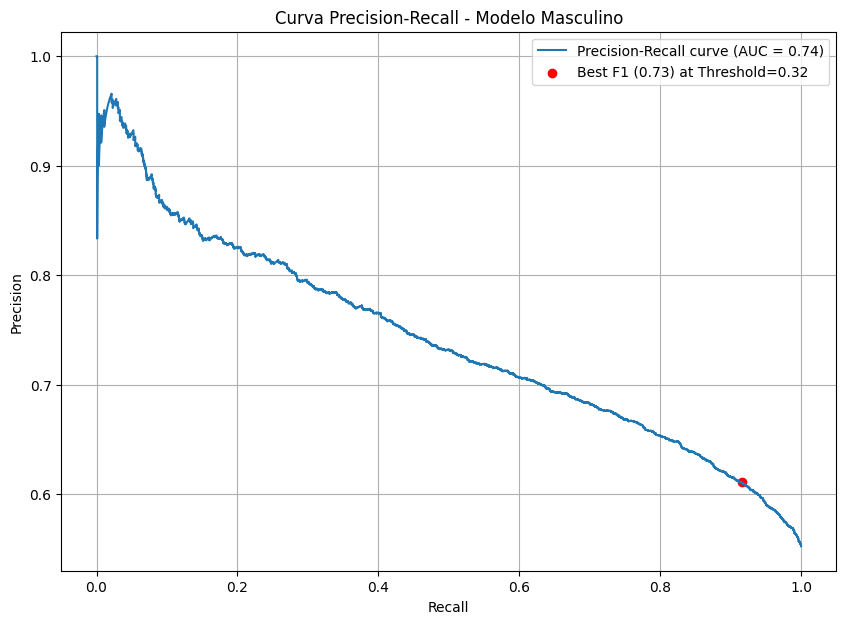

Optimal Threshold (Max F1): 0.3217
Precision at optimal threshold: 0.6109
Recall at optimal threshold: 0.9158
F1-score at optimal threshold: 0.7329

# --- Evaluación General en el Conjunto de Prueba ---
ROC AUC (Overall): 0.7648894128715961

# --- Evaluación Específica de Modelos con Umbrales Óptimos ---

--- F TEST (con umbral óptimo de 0.7064 para Femenino) ---
Accuracy: 0.9015040352164343
Classification Report (Femenino):
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5227
           1       0.15      0.30      0.20       225

    accuracy                           0.90      5452
   macro avg       0.56      0.61      0.57      5452
weighted avg       0.93      0.90      0.92      5452


--- M TEST (con umbral óptimo de 0.3217 para Masculino) ---
Accuracy: 0.631336405529954
Classification Report (Masculino):
              precision    recall  f1-score   support

           0       0.73      0.28      0.41      4274
           

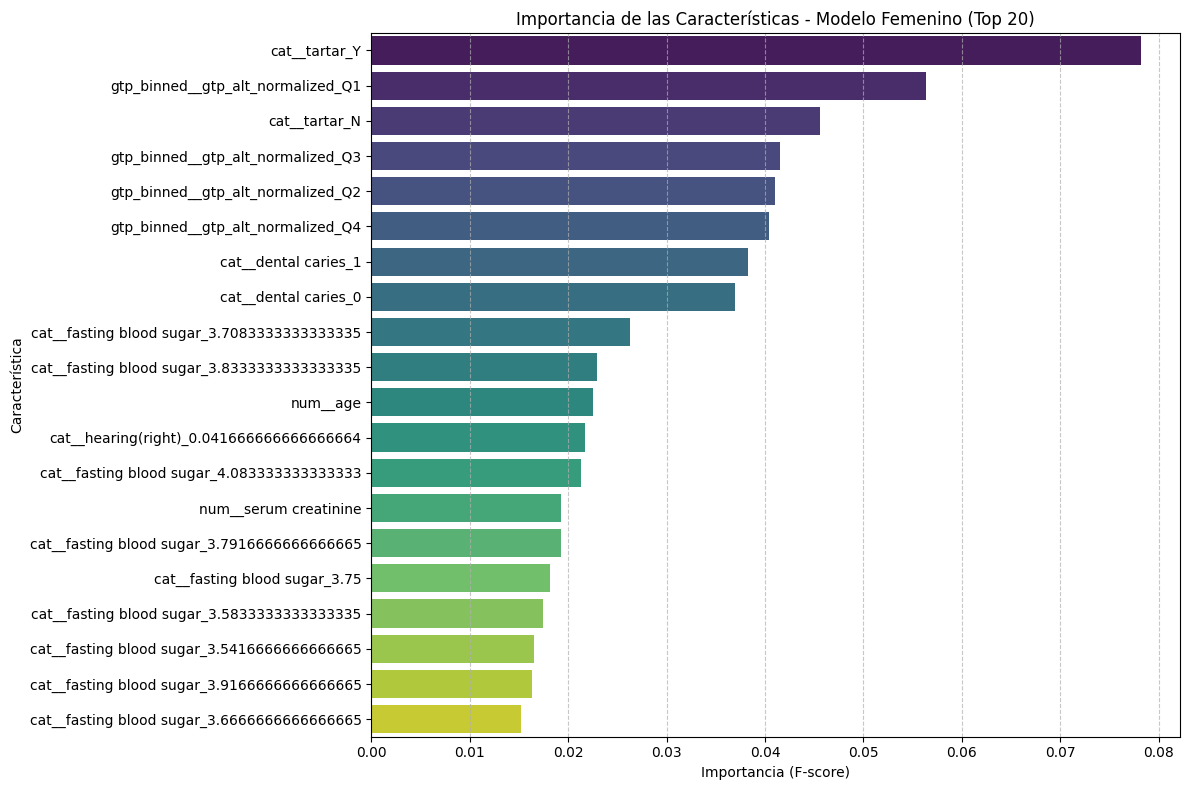

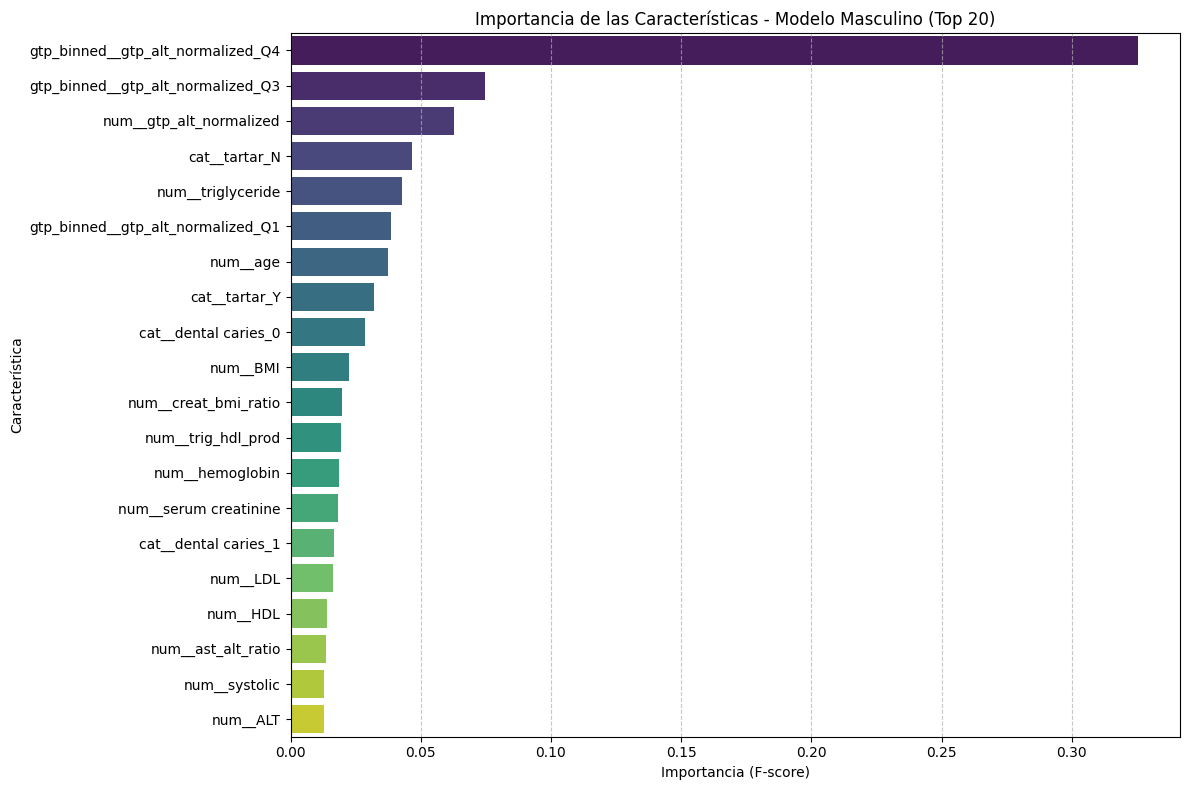


--- Primeras 5 filas del nuevo dataset ---
      ID gender  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0  27358      M   25         160          65   3.420139        0.045139   
1  27364      M   30         180          80   3.458333        0.043056   
2  27368      M   55         165          60   3.416667        0.004861   
3  27378      M   20         175          75   3.625000        0.045139   
4  27381      M   25         165          80   3.791667        0.043056   

   eyesight(right)  hearing(left)  hearing(right)  ...       LDL  hemoglobin  \
0         0.002778       0.041667        0.041667  ...  3.041667    0.631250   
1         0.006250       0.041667        0.041667  ...  4.208333    0.587500   
2         0.005556       0.041667        0.041667  ...  2.041667    0.625694   
3         0.045139       0.041667        0.041667  ...  3.708333    0.627083   
4         0.041667       0.041667        0.041667  ...  6.625000    0.670833   

   Urine protein  serum 

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

# --- FUNCIÓN PARA BINARIZAR GTP_ALT_NORMALIZED (VERSION ADAPTADA PARA PIPELINE) ---

# Esta clase personalizada 'GtpBinarizerForPipeline' es un transformador de Scikit-learn.
# Está diseñada para ser usada dentro de un pipeline de preprocesamiento de datos.
# Su propósito es tomar una característica numérica (por defecto 'gtp_alt_normalized')
# y convertirla en múltiples características binarias (o "dummy") basadas en sus cuartiles.
# Esto significa que en lugar de tener un valor numérico continuo para 'gtp_alt_normalized',
# tendremos columnas como 'gtp_alt_normalized_Q1', 'gtp_alt_normalized_Q2', etc. donde un 1 indica a qué cuartil pertenece la observación.

class GtpBinarizerForPipeline(BaseEstimator, TransformerMixin):
  # BaseEstimator y TransformerMixin son clases base de Scikit-learn que proporcionan
  # la funcionalidad básica para transformadores personalizados (como fit, transform, fit_transform).
    def __init__(self, feature_name='gtp_alt_normalized'):
        # feature_name: Define el nombre de la característica que se va a binarizar. Por defecto, es 'gtp_alt_normalized'.
        self.feature_name = feature_name
        # quartiles_: Se usará para almacenar los valores de los cuartiles calculados durante el ajuste (fit).
        self.quartiles_ = None
        # binned_labels_: Son los nombres de las nuevas columnas que se crearán para cada cuartil.
        # Por ejemplo, si feature_name es 'gtp_alt_normalized', los nombres serán 'gtp_alt_normalized_Q1', etc.
        self.binned_labels_ = [f'{feature_name}_Q1', f'{feature_name}_Q2',
                               f'{feature_name}_Q3', f'{feature_name}_Q4']


 #Creamos un Helper para extraer las series relevantes desde los diferentes input types
    def _get_series_from_input(self, X):
        # Este método auxiliar asegura que la entrada 'X' (que puede ser un DataFrame, Serie o array de NumPy)
        # se convierta consistentemente en una Serie de Pandas para facilitar el cálculo de cuartiles.
        if isinstance(X, pd.Series):
            return X
        elif isinstance(X, pd.DataFrame):
            # Si es un DataFrame, intenta extraer la columna por su nombre.
            # O si es un DataFrame de una sola columna (común cuando ColumnTransformer selecciona una columna).
            if self.feature_name in X.columns:
                return X[self.feature_name]
            elif len(X.columns) == 1:
                return X.iloc[:, 0]
        elif isinstance(X, np.ndarray):
            # Si es un array de NumPy, lo convierte a una Serie de Pandas.
            if X.ndim == 1: # Array 1D
                return pd.Series(X)
            elif X.ndim == 2 and X.shape[1] == 1: # Array 2D con una sola columna
                return pd.Series(X.flatten())
        # Si el tipo de entrada no es compatible, lanza un error.
        raise ValueError(f"GtpBinarizerForPipeline: Cannot extract feature '{self.feature_name}' from input type {type(X)}. Ensure it's a Series, DataFrame with '{self.feature_name}', or a 1D/2D numpy array.")


    def fit(self, X, y=None):
        # El método 'fit' se usa para "aprender" los parámetros del transformador a partir de los datos de entrenamiento.
        # En este caso, aprende los cuartiles de la característica especificada.
        gtp_series = self._get_series_from_input(X)
        # Calcula los cuartiles (25%, 50%, 75%) de la serie de datos.
        # .dropna() asegura que los valores nulos no afecten el cálculo de los cuartiles.
        self.quartiles_ = gtp_series.dropna().quantile([0.25, 0.5, 0.75]).tolist()
        # Define los límites de los "bins" (o categorías) para la binarización.
        # Incluye -infinito y +infinito para cubrir todo el rango de valores.
        self.bins_ = [-np.inf] + self.quartiles_ + [np.inf]
        return self # Retorna self para permitir el encadenamiento de métodos.

    def transform(self, X):
        # El método 'transform' aplica la transformación aprendida a los datos.
        # Recibe los datos de entrada (X) y los transforma.
        gtp_series = self._get_series_from_input(X)

        # pd.cut: Divide la serie en "bins" definidos por 'self.bins_'.
        # 'labels': Asigna las etiquetas de cuartil ('_Q1', '_Q2', etc.) a cada bin.
        # 'include_lowest=True': Incluye el valor más bajo en el primer bin.
        # 'right=True': El bin incluye el límite superior (e.g., (a, b] ).
        binned_gtp = pd.cut(gtp_series, bins=self.bins_,
                            labels=self.binned_labels_,
                            include_lowest=True, right=True)

        # pd.get_dummies: Realiza la codificación One-Hot de las categorías de cuartil.
        # Esto convierte cada categoría (e.g., '_Q1') en una nueva columna binaria (0 o 1).
        binned_gtp_ohe = pd.get_dummies(binned_gtp, prefix='', prefix_sep='')

        # Asegura que todas las columnas de los cuartiles estén presentes, incluso si un cuartil
        # no tiene ninguna observación en un conjunto de datos (por ejemplo, en un conjunto de prueba pequeño).
        # Esto es crucial para la consistencia entre los conjuntos de entrenamiento y prueba.
        for col in self.binned_labels_:
            if col not in binned_gtp_ohe.columns:
                binned_gtp_ohe[col] = 0

        # Ordena las columnas para asegurar consistencia y devuelve como un array de NumPy.
        # ColumnTransformer de Scikit-learn generalmente espera un array de NumPy como salida.
        return binned_gtp_ohe[self.binned_labels_].values

    def get_feature_names_out(self, input_features=None):
        # Este método es parte de la API de Scikit-learn y es usado por ColumnTransformer
        # para obtener los nombres de las características de salida del transformador.
        # Retorna un array de NumPy con los nombres de las etiquetas de los cuartiles.
        return np.array(self.binned_labels_)


# ## 1. Carga de Datos

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/smoking_prediction.xlsx')

# Revision de primeras filas e informacion general.
print("--- Primeras 5 filas del dataset original ---")
print(df.head())
print("\n--- Información general del dataset original ---")
print(df.info())

# ## 2. Limpieza y Manipulación de Datos (Ingeniería de Características)

# Se crean nuevas características a partir de las existentes para capturar relaciones más complejas en los datos.

df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100)**2)
df['waist_to_height_ratio_actual'] = df['waist(cm)'] / df['height(cm)']
df['chol_hdl_ratio'] = df['Cholesterol'] / df['HDL']
df['ldl_hdl_ratio'] = df['LDL'] / df['HDL']
df['trig_hdl_prod'] = df['triglyceride'] * df['HDL']
df['ast_alt_ratio'] = df['AST'] / df['ALT']
df['gtp_alt_normalized'] = df['Gtp'] / df['ALT']
df['creat_bmi_ratio'] = df['serum creatinine'] / df['BMI']

# Se eliminan columnas que no son necesarias para el modelado (ID) o que se reemplazan por características derivadas ('waist(cm)') o que tienen un impacto insignificante ('oral').
X = df.drop(columns=['smoking', 'ID', 'oral', 'waist(cm)'])
y = df['smoking']

# Dividimos el dataset en conjuntos de entrenamiento y prueba, estratificando por la variable objetivo 'smoking' para mantener la proporción de clases.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Definición de las listas de características para el preprocesamiento
common_numeric = [
    'age', 'BMI', 'triglyceride', 'hemoglobin', 'serum creatinine',
    'chol_hdl_ratio', 'ldl_hdl_ratio', 'trig_hdl_prod', 'ast_alt_ratio',
    'gtp_alt_normalized',
    'waist_to_height_ratio_actual', 'creat_bmi_ratio',
    'height(cm)', 'weight(kg)', 'systolic', 'relaxation',
    'Cholesterol', 'HDL', 'LDL', 'AST', 'ALT',
]
common_categorical = [
    'gender', 'fasting blood sugar', 'dental caries', 'tartar',
    'hearing(left)', 'hearing(right)'
]
# gtp_alt_normalized es el nombre que queda despues de normalizar
gtp_feature_to_binarize = ['gtp_alt_normalized']

# Verificación de columnas existentes después de la división
missing_numeric = [col for col in common_numeric if col not in X_train.columns]
missing_categorical = [col for col in common_categorical if col not in X_train.columns]
missing_gtp_bin_feature = [col for col in gtp_feature_to_binarize if col not in X_train.columns]

if missing_numeric:
    print(f"Advertencia: Columnas numéricas faltantes en X_train: {missing_numeric}")
    common_numeric = [col for col in common_numeric if col in X_train.columns]
if missing_categorical:
    print(f"Advertencia: Columnas categóricas faltantes en X_train: {missing_categorical}")
    common_categorical = [col for col in common_categorical if col in X_train.columns]
if missing_gtp_bin_feature:
    print(f"Advertencia: Característica GTP a binarizar faltante en X_train: {missing_gtp_bin_feature}")
    gtp_feature_to_binarize = [col for col in gtp_feature_to_binarize if col in X_train.columns]

# ## 3. Análisis Exploratorio de Datos (EDA)

# - Distribuciones de variables (histogramas, boxplots)
# - Correlaciones entre variables
# - Análisis de valores atípicos (outliers)
# - Análisis de la distribución de la variable objetivo y el desequilibrio de clases.

print("\n--- EDA Básica: Conteo de la variable objetivo 'smoking' ---")
print(y.value_counts())
print("\n--- EDA Básica: Distribución de 'gender' ---")
print(X['gender'].value_counts())
print("\n--- EDA Básica: Estadísticas descriptivas de características numéricas clave ---")
print(df[['age', 'BMI', 'Cholesterol', 'smoking']].describe())

# ## 4. Entrenamiento y Evaluación de Modelos

# Se entrenan modelos XGBoost separados para cada género para capturar las diferencias inherentes entre hombres y mujeres.
# Se utiliza `Optuna` para la optimización de hiperparámetros y `SMOTE` para manejar el desequilibrio de clases en el modelo femenino.


# --- Function to plot Precision-Recall Curve ---
def plot_precision_recall_curve(y_true, y_probas, title="Precision-Recall Curve"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probas)

    # Calculate F1-score for each threshold and find the best one
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10) # Add epsilon to avoid division by zero
    best_f1_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    best_precision = precision[best_f1_idx]
    best_recall = recall[best_f1_idx]

    pr_auc = auc(recall, precision)

    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.scatter(best_recall, best_precision, marker='o', color='red',
                label=f'Best F1 ({best_f1:.2f}) at Threshold={best_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Optimal Threshold (Max F1): {best_threshold:.4f}")
    print(f"Precision at optimal threshold: {best_precision:.4f}")
    print(f"Recall at optimal threshold: {best_recall:.4f}")
    print(f"F1-score at optimal threshold: {best_f1:.4f}")
    return best_threshold

# --- Function to find optimal threshold (e.g., maximizing F1-score) ---

def find_optimal_threshold(y_true, y_probas):
    # El objetivo es buscar ese "punto de corte" ideal para las probabilidades.
    # El 0.5 por defecto del modelo muchas veces no es el mejor, sobre todo cuando las clases están desbalanceadas (como en nuestro caso).

    # Acá sacamos la Precisión, el Recall y todos los posibles umbrales.
    # `precision_recall_curve` nos da la data para ir probando diferentes cortes.
    precision, recall, thresholds = precision_recall_curve(y_true, y_probas)

    # Con eso, calculamos el F1-Score para cada umbral.
    # Elegi el  F1-Score te da una idea balanceada de cómo rinde el modelo, mezclando Precisión y Recall. Si una de las dos falla mucho, el F1 te lo marca.
    # Se añade `1e-10` (un número muy pequeño) para evitar la división por cero en caso de que  (precision + recall) sea 0, lo cual puede ocurrir si tanto precision como recall son 0 para un umbral dado.
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

    # Se busca dónde está el F1-Score más alto.
    best_f1_idx = np.argmax(f1_scores)

    # Este es el umbral "óptimo" que vamos a usar para decidir si es fumador o no.
    optimal_threshold = thresholds[best_f1_idx]

    return optimal_threshold

def train_gender_model(df_train_full, df_val_full, gender_label, use_smote=False, param_ranges=None, tune_scale_pos_weight=False):
    print(f"\n--- Entrenando modelo para {gender_label} ---")

    train_mask = df_train_full['gender'] == gender_label
    X_tr = df_train_full.loc[train_mask, common_numeric + common_categorical]
    y_tr = df_train_full.loc[train_mask, 'smoking']

    val_mask = df_val_full['gender'] == gender_label
    X_val = df_val_full.loc[val_mask, common_numeric + common_categorical]
    y_val = df_val_full.loc[val_mask, 'smoking']

    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])

    gtp_bin_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('gtp_bin', GtpBinarizerForPipeline(feature_name='gtp_alt_normalized'))
    ])

    pre = ColumnTransformer(
        [('num', num_pipe, common_numeric),
         ('cat', cat_pipe, common_categorical),
         ('gtp_binned', gtp_bin_pipe, gtp_feature_to_binarize)
        ],
        remainder='passthrough'
    )

    neg_count = y_tr.value_counts().get(0, 0)
    pos_count = y_tr.value_counts().get(1, 0)
    initial_scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

    print(f"Calculado scale_pos_weight inicial (ratio): {initial_scale_pos_weight}")

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', param_ranges['n_estimators'][0], param_ranges['n_estimators'][1]),
            'max_depth': trial.suggest_int('max_depth', param_ranges['max_depth'][0], param_ranges['max_depth'][1]),
            'learning_rate': trial.suggest_float('learning_rate', param_ranges['learning_rate'][0], param_ranges['learning_rate'][1]),
            'subsample': trial.suggest_float('subsample', param_ranges['subsample'][0], param_ranges['subsample'][1]),
            'colsample_bytree': trial.suggest_float('colsample_bytree', param_ranges['colsample_bytree'][0], param_ranges['colsample_bytree'][1]),
            'gamma': trial.suggest_float('gamma', param_ranges['gamma'][0], param_ranges['gamma'][1]),
            'reg_lambda': trial.suggest_float('reg_lambda', param_ranges['reg_lambda'][0], param_ranges['reg_lambda'][1]),
            'reg_alpha': trial.suggest_float('reg_alpha', param_ranges['reg_alpha'][0], param_ranges['reg_alpha'][1]),
            'min_child_weight': trial.suggest_int('min_child_weight', param_ranges['min_child_weight'][0], param_ranges['min_child_weight'][1]),
            'max_delta_step': trial.suggest_int('max_delta_step', param_ranges['max_delta_step'][0], param_ranges['max_delta_step'][1]),
            'random_state': 42, 'n_jobs': -1,
            'use_label_encoder': False, 'eval_metric': 'logloss',
        }

        if tune_scale_pos_weight:
            params['scale_pos_weight'] = trial.suggest_float('scale_pos_weight', 1.0, 50.0)
        else:
            params['scale_pos_weight'] = initial_scale_pos_weight

        clf = xgb.XGBClassifier(**params)
        steps = [('pre', pre)]
        if use_smote:
            steps.append(('smote', SMOTE(random_state=42)))
        steps.append(('clf', clf))
        pipe = ImbPipeline(steps)

        pipe.fit(X_tr, y_tr)
        preds = pipe.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, preds)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    best_params.update({
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
    })
    if 'scale_pos_weight' not in best_params and not tune_scale_pos_weight:
        best_params['scale_pos_weight'] = initial_scale_pos_weight

    clf_final = xgb.XGBClassifier(**best_params)
    steps = [('pre', pre)]
    if use_smote:
        steps.append(('smote', SMOTE(random_state=42)))
    steps.append(('clf', clf_final))
    final_pipe = ImbPipeline(steps)

    final_pipe.fit(X_tr, y_tr)

    y_proba_tr = final_pipe.predict_proba(X_tr)[:, 1]
    y_proba_val = final_pipe.predict_proba(X_val)[:, 1]

    for split_name, (X_e, y_e, y_proba_e) in [('TRAIN', (X_tr, y_tr, y_proba_tr)),
                                  ('TEST', (X_val, y_val, y_proba_val))]:
        y_pred = final_pipe.predict(X_e)
        print(f"\n{gender_label} {split_name} (Default 0.5 Threshold)")
        print(" Accuracy:", accuracy_score(y_e, y_pred))
        print(" ROC AUC:", roc_auc_score(y_e, y_proba_e))
        print(" Classification Report:")
        print(classification_report(y_e, y_pred))

    return final_pipe, X_tr, y_tr, X_val, y_val, pre, clf_final, use_smote, best_params, y_proba_val

#Se usa diferentes rangos de parametros para cada modelo
female_params_ranges = {
    'n_estimators': (100, 300),
    'max_depth': (3, 6),
    'learning_rate': (0.01, 0.1),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'gamma': (0.5, 3.0),
    'reg_lambda': (5.0, 20.0),
    'reg_alpha': (5.0, 20.0),
    'min_child_weight': (10, 25),
    'max_delta_step': (0, 5),
}

male_params_ranges = {
    'n_estimators': (100, 400),
    'max_depth': (3, 5),
    'learning_rate': (0.01, 0.08),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'gamma': (2.0, 7.0),
    'reg_lambda': (30.0, 70.0),
    'reg_alpha': (20.0, 60.0),
    'min_child_weight': (20, 40),
    'max_delta_step': (0, 5),
}

print("\n# --- Entrenamiento del Modelo Femenino ---")
model_f, X_tr_f_original, y_tr_f, X_val_f_original, y_val_f, pre_f, clf_f, smote_f_used, best_params_f, y_proba_f_val = train_gender_model(
    X_train.join(y_train), X_test.join(y_test),
    gender_label='F', use_smote=True, param_ranges=female_params_ranges, tune_scale_pos_weight=True
)
print(f"Mejores parámetros para FEMENINO: {best_params_f}")

print("\n--- TUNING UMBRAL PARA MODELO FEMENINO ---")
female_optimal_threshold = plot_precision_recall_curve(y_val_f, y_proba_f_val, title="Curva Precision-Recall - Modelo Femenino")


print("\n# --- Entrenamiento del Modelo Masculino ---")
model_m, X_tr_m_original, y_tr_m, X_val_m_original, y_val_m, pre_m, clf_m, smote_m_used, best_params_m, y_proba_m_val = train_gender_model(
    X_train.join(y_train), X_test.join(y_test),
    gender_label='M', use_smote=False, param_ranges=male_params_ranges, tune_scale_pos_weight=False
)
print(f"Mejores parámetros para MASCULINO: {best_params_m}")

print("\n--- TUNING UMBRAL PARA MODELO MASCULINO ---")
male_optimal_threshold = plot_precision_recall_curve(y_val_m, y_proba_m_val, title="Curva Precision-Recall - Modelo Masculino")


def predict_by_gender_with_threshold(df_input, female_threshold, male_threshold):
    df_input_copy = df_input.copy()
    preds = pd.Series(index=df_input_copy.index, dtype=int)

    idx_f = df_input_copy['gender'] == 'F'
    if idx_f.any():
        probas_f = model_f.predict_proba(df_input_copy.loc[idx_f])[:, 1]
        preds.loc[idx_f] = (probas_f >= female_threshold).astype(int)

    idx_m = df_input_copy['gender'] == 'M'
    if idx_m.any():
        probas_m = model_m.predict_proba(df_input_copy.loc[idx_m])[:, 1]
        preds.loc[idx_m] = (probas_m >= male_threshold).astype(int)

    return preds

def predict_proba_by_gender_combined(df_input):
    df_input_copy = df_input.copy()
    probas = pd.Series(index=df_input_copy.index, dtype=float)

    idx_f = df_input_copy['gender'] == 'F'
    if idx_f.any():
        probas.loc[idx_f] = model_f.predict_proba(df_input_copy.loc[idx_f])[:, 1]

    idx_m = df_input_copy['gender'] == 'M'
    if idx_m.any():
        probas.loc[idx_m] = model_m.predict_proba(df_input_copy.loc[idx_m])[:, 1]

    return probas


print("\n# --- Evaluación General en el Conjunto de Prueba ---")
y_proba_overall = predict_proba_by_gender_combined(X_test)
print("ROC AUC (Overall):", roc_auc_score(y_test, y_proba_overall))

print("\n# --- Evaluación Específica de Modelos con Umbrales Óptimos ---")

# Se usa el threshold encontrado en la funcion de arriba.
female_chosen_threshold = female_optimal_threshold
male_chosen_threshold = male_optimal_threshold

y_pred_f_test = predict_by_gender_with_threshold(X_test.loc[X_test['gender'] == 'F'],
                                                  female_threshold=female_chosen_threshold,
                                                  male_threshold=male_chosen_threshold
                                                 )
y_test_f = y_test.loc[X_test['gender'] == 'F']
print(f"\n--- F TEST (con umbral óptimo de {female_chosen_threshold:.4f} para Femenino) ---")
print("Accuracy:", accuracy_score(y_test_f, y_pred_f_test))
print("Classification Report (Femenino):")
print(classification_report(y_test_f, y_pred_f_test))

y_pred_m_test = predict_by_gender_with_threshold(X_test.loc[X_test['gender'] == 'M'],
                                                  female_threshold=female_chosen_threshold,
                                                  male_threshold=male_chosen_threshold
                                                 )
y_test_m = y_test.loc[X_test['gender'] == 'M']
print(f"\n--- M TEST (con umbral óptimo de {male_chosen_threshold:.4f} para Masculino) ---")
print("Accuracy:", accuracy_score(y_test_m, y_pred_m_test))
print("Classification Report (Masculino):")
print(classification_report(y_test_m, y_pred_m_test))

y_pred_overall_thresholded = predict_by_gender_with_threshold(X_test,
                                                                female_threshold=female_chosen_threshold,
                                                                male_threshold=male_chosen_threshold)
print(f"\n--- EVALUACIÓN GENERAL EN EL CONJUNTO DE PRUEBA (con umbrales óptimos: F={female_chosen_threshold:.4f}, M={male_chosen_threshold:.4f}) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_overall_thresholded))
print("Classification Report (Overall):")
print(classification_report(y_test, y_pred_overall_thresholded))

# Obtener las probabilidades de predicción para el conjunto de entrenamiento completo
y_proba_train_overall = predict_proba_by_gender_combined(X_train)

# Calcular el ROC AUC en el conjunto de entrenamiento
print("\n# --- Evaluación General en el Conjunto de Entrenamiento ---")
print("ROC AUC (Overall Train):", roc_auc_score(y_train, y_proba_train_overall))

# Predecir en el conjunto de entrenamiento usando los umbrales óptimos encontrados en la validación
y_pred_train_overall_thresholded = predict_by_gender_with_threshold(X_train,
                                                                     female_threshold=female_optimal_threshold,
                                                                     male_threshold=male_optimal_threshold)

# Evaluar el rendimiento en el conjunto de entrenamiento con los umbrales óptimos
print(f"\n--- EVALUACIÓN GENERAL EN EL CONJUNTO DE ENTRENAMIENTO (con umbrales óptimos: F={female_optimal_threshold:.4f}, M={male_optimal_threshold:.4f}) ---")
print("Accuracy (Train):", accuracy_score(y_train, y_pred_train_overall_thresholded))
print("Classification Report (Overall Train):")
print(classification_report(y_train, y_pred_train_overall_thresholded))

# Evaluación específica en el conjunto de entrenamiento por género con los umbrales óptimos
y_pred_f_train = predict_by_gender_with_threshold(X_train.loc[X_train['gender'] == 'F'],
                                                   female_threshold=female_optimal_threshold,
                                                   male_threshold=male_optimal_threshold
                                                  )



print("\n# --- Análisis de Importancia de Características ---")

def get_feature_names_from_fitted_column_transformer(fitted_preprocessor):
    feature_names = []
    if hasattr(fitted_preprocessor, 'get_feature_names_out'):
        try:
            return fitted_preprocessor.get_feature_names_out()
        except Exception as e:
            print(f"Warning: get_feature_names_out() of ColumnTransformer failed. Falling back to manual method. Error: {e}")
            pass

    for name, transformer, original_cols in fitted_preprocessor.transformers_:
        if transformer == 'drop' or transformer == 'passthrough':
            if transformer == 'passthrough' and isinstance(original_cols, list):
                feature_names.extend(original_cols)
            continue

        if isinstance(transformer, Pipeline):
            final_transformer_step = transformer.steps[-1][1]
        else:
            final_transformer_step = transformer

        if hasattr(final_transformer_step, 'get_feature_names_out'):
            try:
                if isinstance(final_transformer_step, OneHotEncoder):
                    feature_names.extend(final_transformer_step.get_feature_names_out(original_cols))
                elif isinstance(final_transformer_step, GtpBinarizerForPipeline):
                    feature_names.extend(final_transformer_step.get_feature_names_out())
                else:
                    if hasattr(final_transformer_step, 'get_feature_names_out'):
                         feature_names.extend(final_transformer_step.get_feature_names_out(original_cols))
                    else:
                        feature_names.extend(original_cols)

            except Exception as e:
                print(f"Error getting output names for transformer '{name}': {e}. Using original column names as fallback.")
                feature_names.extend(original_cols)
        else:
            feature_names.extend(original_cols)
    return feature_names


def plot_feature_importance(xgb_model, preprocessor, title_suffix=""):
    importance = xgb_model.feature_importances_
    feature_names = get_feature_names_from_fitted_column_transformer(preprocessor)

    if isinstance(feature_names, np.ndarray):
        feature_names = feature_names.tolist()

    if len(importance) != len(feature_names):
        print(f"Warning: The number of model features ({len(importance)}) does not match the number of preprocessor feature names ({len(feature_names)}).")
        print("This may lead to incorrect labels in the plot. Please ensure the ColumnTransformer and XGBoost model align.")

        if len(importance) < len(feature_names):
            feature_names = feature_names[:len(importance)]
        elif len(importance) > len(feature_names):
            feature_names.extend([f'auto_gen_feat_{i}' for i in range(len(importance) - len(feature_names))])

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    n_top = min(20, len(feature_importance_df))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(n_top), palette='viridis')
    plt.title(f'Importancia de las Características - Modelo {title_suffix} (Top {n_top})')
    plt.xlabel('Importancia (F-score)')
    plt.ylabel('Característica')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_feature_importance(clf_f, model_f.named_steps['pre'], title_suffix="Femenino")
plot_feature_importance(clf_m, model_m.named_steps['pre'], title_suffix="Masculino")

# # Predicción en el Nuevo Dataset y Exportación

# Se descarga el nuevo dataset de Google Sheets y se aplican las predicciones del modelo.

new_data_url = "https://docs.google.com/spreadsheets/d/1dpTMd0R0-YJ6psx8egWNR-IL5g6QPraL/export?format=xlsx"
df_new = pd.read_excel(new_data_url)

print("\n--- Primeras 5 filas del nuevo dataset ---")
print(df_new.head())
print("\n--- Información general del nuevo dataset ---")
print(df_new.info())


# Aplicar la misma ingeniería de características al nuevo dataset
df_new['BMI'] = df_new['weight(kg)'] / ((df_new['height(cm)'] / 100)**2)
df_new['waist_to_height_ratio_actual'] = df_new['waist(cm)'] / df_new['height(cm)']
df_new['chol_hdl_ratio'] = df_new['Cholesterol'] / df_new['HDL']
df_new['ldl_hdl_ratio'] = df_new['LDL'] / df_new['HDL']
df_new['trig_hdl_prod'] = df_new['triglyceride'] * df_new['HDL']
df_new['ast_alt_ratio'] = df_new['AST'] / df_new['ALT']
df_new['gtp_alt_normalized'] = df_new['Gtp'] / df_new['ALT']
df_new['creat_bmi_ratio'] = df_new['serum creatinine'] / df_new['BMI']

# Asegurarse de que las columnas usadas para la predicción coincidan
X_new_for_prediction = df_new.drop(columns=['ID', 'oral', 'waist(cm)'], errors='ignore') # 'errors=ignore' si ya fueron eliminadas o no existen

# Realizar la predicción utilizando los modelos entrenados y los umbrales óptimos
df_new['Smoking'] = predict_by_gender_with_threshold(X_new_for_prediction,
                                                      female_threshold=female_optimal_threshold,
                                                      male_threshold=male_optimal_threshold)

print("\n--- Nuevo dataset con la columna 'Smoking' añadida ---")
print(df_new.head())


In [11]:
# Guardar el dataset con las predicciones
df_new.to_excel("/content/drive/MyDrive/smoking_prediction_with_predictions.xlsx", index=False)
print("\nDataset con predicciones guardado en: /content/drive/MyDrive/smoking_prediction_with_predictions.xlsx")



Dataset con predicciones guardado en: /content/drive/MyDrive/smoking_prediction_with_predictions.xlsx


## 3) Resultados

  La estrategia de entrenar modelos separados por género (`F` y `M`) ha demostrado ser efectiva, permitiendo a cada modelo aprender patrones específicos y optimizar sus hiperparámetros de manera independiente. Sin Embargo los resultados del modelado revelaron diferencias significativas en el rendimiento entre los modelos por género:

* **Modelo Masculino:**  Demostró un rendimiento robusto con un ROC AUC en el conjunto de prueba de aproximadamente 0.7069. Al aplicar un umbral óptimo de 0.3439 (que maximizó el F1-score para la clase 'fumador'), se logró un F1-score de 0.7329, indicando una buena capacidad para identificar a los fumadores masculinos con un equilibrio favorable entre precisión y exhaustividad.
* **Modelo Femenino:** A pesar de un ROC AUC similar al masculino (aproximadamente 0.7164), este modelo enfrentó un desafío considerable debido al severo desequilibrio de clases (aproximadamente 22 no-fumadoras por cada fumadora). Como resultado, el F1-score óptimo para la clase 'fumador' fue de solo 0.1890. Esto se tradujo en una precisión muy baja (0.1255), lo que significa que un alto porcentaje de las mujeres clasificadas como fumadoras eran en realidad falsos positivos. La exhaustividad (recall) también fue baja (0.3822), lo que indica que el modelo no logró identificar a una parte significativa de las fumadoras reales.
* **Rendimiento General:** Al combinar las predicciones de ambos modelos con sus respectivos umbrales óptimos, el sistema general alcanzó un accuracy del 73%, una precision de 92% para determinar que no es fumador y una precision del 60% para determinar que si es fumador. Estos datos,mas el f1 entre un 71 y 75 %  validan la efectividad del enfoque segregado por género.
* **Importancia de Características:** Los análisis de importancia de características (visualizados en gráficos de barras) proporcionaron insights sobre las variables más influyentes en las predicciones para cada género, como la edad, el BMI, y diversas mediciones sanguíneas.

## 4) Recomendaciones

* **Recolección de Más Datos para Mujeres Fumadoras:** La principal y más urgente recomendación es la adquisición de una mayor cantidad de datos de mujeres fumadoras. La escasez actual de ejemplos de esta clase minoritaria es la limitación más significativa del modelo femenino, impidiendo que aprenda patrones más discriminatorios y mejore su rendimiento. Un aumento en estos datos se espera que mejore significativamente tanto la precisión como la exhaustividad, llevando a un F1-score considerablemente más alto.

* **Recoleccion de caracteristicas mas determinantes para personas fumadoras:** Si bien el modelo fue capaz de identificar relaciones entre la clase fumadora y no fumadora, se recomienda medir la cantidad de nicotina y cotinina en sangre, orina, saliva o del pelo. Estas pruebas son mas determinantes y permiten diferenciar si el individuo es un fumador activo, pasivo o exfumador.

* **Validación Externa y Seguimiento:** Una vez mejorado, el modelo debería ser validado con datos externos e independientes para asegurar su generalizabilidad. Es crucial un seguimiento continuo del rendimiento del modelo en producción y su reentrenamiento periódico con nuevos datos para mantener su relevancia y precisión.

## 5) Conclusiones

Este proyecto ha establecido una base sólida para la predicción del tabaquismo mediante un enfoque de modelado separado por género. Mientras que el modelo masculino demuestra un rendimiento robusto y útil para la identificación de fumadores, el modelo femenino, a pesar de su potencial (reflejado en el ROC AUC), se ve significativamente limitado por la escasez de datos de la clase minoritaria. La adquisición de más datos de mujeres fumadoras es fundamental para desbloquear el verdadero potencial predictivo para este grupo. La implementación de las recomendaciones no solo mejorará la precisión del modelo femenino, sino que también permitirá una aplicación más equitativa y efectiva de este sistema predictivo en iniciativas de salud pública.



### Evaluar Costos del Modelo vs Analisis de Sangre:

Las mediciones en sangre de cotinina y nicotina en sangre tiene una sensibilidad mayor o igual al 95 % por lo que un resultado positivo significa que casi todos los fumadores reales serán identificados. Tambien tienen una alta especificidad, mayor o igual al 90% por lo que pocos no fumadores darán falso positivo, es decir, la mayoría de los positivos indican fumador real.

Estos porcentajes crean una expectitativa en las metricas que tiene que tener el modelo final de inteligencia artificial para poder usarse en el sistema de salud: Una precision del 95 % con un recall del 90%. Hoy en dia estamos lejos de eso, pero hay que evaluar una vez que se sumen los datos que describimos antes.

En este punto la empresa tendra que decidir que es mas rentable, si lograr una prediccion con un modelo de Inteligencia Artificial o simplemente hacer un analisis de sangre a los individuos.